Le but de ce notebook est de développer un modèle de prédiction des prix de ventes des maisons en fonction de leur caractéristiques.

## 1. Importation des packages

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import gradio as gr
import pickle
import io
import base64
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [11]:
#Bibliothèques pour l'analyse de séries temporelles
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
# Configuration des options d'affichage de pandas

# Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher toutes les lignes
pd.set_option('display.max_rows', None)

# Éviter le raccourcissement de la largeur des colonnes
pd.set_option('display.width', None)

# Afficher le contenu complet des colonnes sans les tronquer
pd.set_option('display.max_colwidth', None)


In [13]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 2. Importation du dataset et les premières analyses

In [5]:
data = pd.read_csv('C:\\Users\\Utilisateur\\Desktop\\BE\\Fichiers\\archive\\Stage_PFA\\data\\stock_price.csv')

In [6]:
print(f"le dataset contient {data.shape[0]} observations et {data.shape[1]} variables.")
print("=" * 50)
print(f"les types des variables sont :\n{data.dtypes}")

le dataset contient 497472 observations et 7 variables.
les types des variables sont :
symbol     object
date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


In [7]:
# Changement du type de la colonne 'Date' en datetime
data['date'] = pd.to_datetime(data['date'])

In [8]:
data.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


Description du dataset

| Colonne | Signification          | Utilité principale                               |
| ------- | ---------------------- | ------------------------------------------------ |
| symbol  | Symbole de l’action    | Identifier l’entreprise                          |
| date    | Date de la transaction | Analyse temporelle                               |
| open    | Prix d’ouverture       | Étudier les tendances dès le début de la journée |
| high    | Prix le plus haut      | Déterminer les pics d'activité                   |
| low     | Prix le plus bas       | Identifier les chutes du prix                    |
| close   | Prix de clôture        | Suivre l’évolution de la valeur de l’action      |
| volume  | Volume échangé         | Mesurer l’intérêt et la liquidité du titre       |


In [9]:
# les premières statistiques descriptives
print(data.describe().T)


           count                           mean                  min  \
date      497472  2016-01-06 17:16:00.439984896  2014-01-02 00:00:00   
open    497461.0                      86.352275                 1.62   
high    497464.0                      87.132562                 1.69   
low     497464.0                      85.552467                  1.5   
close   497472.0                      86.369082                 1.59   
volume  497472.0                 4253610.897777                  0.0   

                        25%                  50%                  75%  \
date    2015-01-08 00:00:00  2016-01-11 00:00:00  2017-01-06 00:00:00   
open                  41.69                64.97                98.41   
high                  42.09                65.56                99.23   
low                   41.28              64.3537                97.58   
close              41.70375                64.98                98.42   
volume            1080166.5            2084896.5         

In [10]:
# Les valeurs uniques de la colonne 'symbol'
print(f"Le nombre total de valeurs uniques de la colonne 'symbol' sont : \n{data['symbol'].nunique()}")

Le nombre total de valeurs uniques de la colonne 'symbol' sont : 
505


In [11]:
# Catégorisons les entreprises en fonction des valeurs boursières
data['category']=pd.cut(
    data['close'],
    bins=[0, 5, 20, 100, 500, 1000, np.inf],
    labels=[
        'penny_stock',               # < 5 $
        'petite_capitalisation',   # 5–20 $
        'entreprise_moyenne',    # 20–100 $
        'grande_entreprise',    # 100–500 $
        'tres_chere',          # 500–1000 $
        'action_premium'         # > 1000 $
    ]
)


In [12]:
# Les lignes ou il y a une valeur manquante
missing_values = data[data.isnull().any(axis=1)]
print(f"Le nombre de lignes avec des valeurs manquantes est : {missing_values.shape[0]}")

Le nombre de lignes avec des valeurs manquantes est : 11


In [13]:
print(missing_values)

       symbol       date  open   high    low     close   volume  \
166348   VRTX 2015-05-12   NaN    NaN    NaN  124.0800   569747   
175557   REGN 2015-06-09   NaN    NaN    NaN  526.0900    12135   
182011    WRK 2015-06-26   NaN    NaN    NaN   61.9000      100   
188547    DHR 2015-07-17   NaN  88.76  88.24   88.7200  2056819   
188578     ES 2015-07-17   NaN  48.49  47.85   47.9200  1246786   
188760      O 2015-07-17   NaN  47.31  46.83   46.9900  1229513   
249223    DHR 2016-01-12   NaN    NaN    NaN   88.5500        0   
249438      O 2016-01-12   NaN    NaN    NaN   52.4300        0   
278801     UA 2016-04-07   NaN    NaN    NaN   41.5600        0   
308365    FTV 2016-07-01   NaN    NaN    NaN   49.5400        0   
442107    BHF 2017-07-26   NaN    NaN    NaN   69.0842        3   

                  category  
166348   grande_entreprise  
175557          tres_chere  
182011  entreprise_moyenne  
188547  entreprise_moyenne  
188578  entreprise_moyenne  
188760  entreprise_mo

Le pourcentage de valeur manquante est minime donc on va procéder par la suppression


In [14]:
# Suppresson des valeurs manquantes
data = data.dropna()

In [15]:
# Transformons la colonne 'date' en index
data.set_index('date', inplace=True)
# Vérifions les types de données après la transformation
print(data.dtypes)


symbol        object
open         float64
high         float64
low          float64
close        float64
volume         int64
category    category
dtype: object


In [16]:
data.head()

,symbol,open,high,low,close,volume,category
date,,,,,,,
2014-01-02,AAL,25.0700,25.8200,25.0600,25.3600,8998943,entreprise_moyenne
2014-01-02,AAPL,79.3828,79.5756,78.8601,79.0185,58791957,entreprise_moyenne
2014-01-02,AAP,110.3600,111.8800,109.2900,109.7400,542711,grande_entreprise
2014-01-02,ABBV,52.1200,52.3300,51.5200,51.9800,4569061,entreprise_moyenne
2014-01-02,ABC,70.1100,70.2300,69.4800,69.8900,1148391,entreprise_moyenne


In [17]:
data.columns

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'category'], dtype='object')

TOUT EST PRET POUR L'ANALYSE APPROFONDIE !!!

## Analyse Approfondie

Pour continuer l'analyse nous allons contruire une classe qui va contenir les méthodes d'analyses.

In [18]:
class FinancialTimeSeriesAnalyzer:
    """
    Classe complète pour l'analyse de séries temporelles financières
    """
    
    def __init__(self, data_path=None, data=None):
        """
        Initialise l'analyseur avec les données
        """
        if data is not None:
            self.df = data.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        
        
        # S'assurer que toutes les colonnes numériques sont bien typées
        numeric_columns = self.df.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        # Optimisation pour les grandes séries temporelles
        original_length = len(self.df)
        if original_length > 8000:
            print(f"⚠️  Série temporelle volumineuse détectée ({original_length} observations)")
            print(" Application d'un échantillonnage pour optimiser les performances...")
            
            if original_length > 20000:
                # Pour très grandes séries : échantillonnage uniforme
                step = original_length // 6000
                self.df = self.df.iloc[::step].copy()
            else:
                # Pour séries moyennes : garder plus de données récentes
                keep_recent = min(4000, original_length // 2)
                keep_older = min(2000, original_length - keep_recent)
                
                recent_data = self.df.tail(keep_recent)
                if keep_older > 0:
                    older_data = self.df.head(original_length - keep_recent)
                    step = max(1, len(older_data) // keep_older)
                    older_sampled = older_data.iloc[::step]
                    self.df = pd.concat([older_sampled, recent_data])
                else:
                    self.df = recent_data
            
            print(f"✅ Données optimisées : {len(self.df)} observations conservées (réduction de {original_length - len(self.df)} observations)")
        
    def plot_original_series(self):
        """
        Visualise la série temporelle originale
        """
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Série temporelle complète
        axes[0].plot(self.df.index, self.df['close'], linewidth=1.5, color='blue', alpha=0.8)
        axes[0].set_title('Série Temporelle  - Prix de Clôture', fontsize=16, fontweight='bold')
        axes[0].set_ylabel('Prix ($)', fontsize=12)
        axes[0].grid(True, alpha=0.3)
        
        # Distribution des prix
        axes[1].hist(self.df['close'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1].set_title('Distribution des Prix de Clôture', fontsize=14)
        axes[1].set_xlabel('Prix ($)', fontsize=12)
        axes[1].set_ylabel('Fréquence', fontsize=12)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        self.ts_data = self.df.sort_index().copy()
        
        # Formatage sécurisé des dates
        try:
            start_date = self.ts_data.index.min().strftime('%Y-%m-%d')
            end_date = self.ts_data.index.max().strftime('%Y-%m-%d')
            print(f"Période: {start_date} à {end_date}")
        except:
            print(f"Période: Index {self.ts_data.index.min()} à {self.ts_data.index.max()}")
            
        print(f"Nombre total d'observations: {len(self.ts_data)}")
        return self.ts_data
        
    def decompose_time_series(self, period=365):
        """
        Décompose la série temporelle en tendance, saisonnalité et résidus
        """
        print(f"\n DÉCOMPOSITION DE LA SÉRIE TEMPORELLE (période={period})")
        print("=" * 60)
        
        # Ajustement automatique de la période si nécessaire
        max_period = len(self.ts_data) // 3
        if period > max_period:
            period = max(12, max_period)
            print(f"⚠️  Période ajustée à {period} pour s'adapter à la taille des données")
        
        # Décomposition additive
        decomposition_add = seasonal_decompose(
            self.ts_data['close'], 
            model='additive', 
            period=period
        )
        
        # Décomposition multiplicative
        decomposition_mult = seasonal_decompose(
            self.ts_data['close'], 
            model='multiplicative', 
            period=period
        )
        
        # Visualisation
        fig, axes = plt.subplots(4, 2, figsize=(18, 12))
        
        # Décomposition additive
        decomposition_add.observed.plot(ax=axes[0,0], title='Série Originale (Additif)', color='blue')
        decomposition_add.trend.plot(ax=axes[1,0], title='Tendance (Additif)', color='red')
        decomposition_add.seasonal.plot(ax=axes[2,0], title='Saisonnalité (Additif)', color='green')
        decomposition_add.resid.plot(ax=axes[3,0], title='Résidus (Additif)', color='orange')
        
        # Décomposition multiplicative
        decomposition_mult.observed.plot(ax=axes[0,1], title='Série Originale (Multiplicatif)', color='blue')
        decomposition_mult.trend.plot(ax=axes[1,1], title='Tendance (Multiplicatif)', color='red')
        decomposition_mult.seasonal.plot(ax=axes[2,1], title='Saisonnalité (Multiplicatif)', color='green')
        decomposition_mult.resid.plot(ax=axes[3,1], title='Résidus (Multiplicatif)', color='orange')
        
        for ax in axes.flat:
            ax.grid(True, alpha=0.3)
            
        plt.suptitle('Décomposition de la Série Temporelle', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        self.decomposition = decomposition_add
        return decomposition_add, decomposition_mult
    
    def test_stationarity(self):
        """
        Test de stationnarité avec le test ADF
        """
        print("\n TEST DE STATIONNARITÉ (Augmented Dickey-Fuller)")
        print("=" * 55)
        
        # Nettoyage et préparation des données
        test_data = self.ts_data['close'].dropna()
        
        # Échantillonnage pour le test ADF si les données sont trop volumineuses
        if len(test_data) > 5000:
            # Échantillonnage uniforme
            step = len(test_data) // 5000
            test_data = test_data.iloc[::step]
            print(f" Test sur échantillon de {len(test_data)} observations")
        
        try:
            result = adfuller(test_data)
            
            print(f'Statistique ADF: {result[0]:.6f}')
            print(f'p-value: {result[1]:.6f}')
            print('Valeurs critiques:')
            for key, value in result[4].items():
                print(f'\t{key}: {value:.3f}')
            
            if result[1] <= 0.05:
                print("✅ Résultat: La série est stationnaire (rejette H0)")
                return True
            else:
                print("❌ Résultat: La série n'est pas stationnaire (ne rejette pas H0)")
                return False
                
        except Exception as e:
            print(f"❌ Erreur lors du test ADF: {e}")
            return False
    
    def moving_averages(self, windows=[7, 30, 90]):
        """
        Calcule et visualise les moyennes mobiles
        """
        print(f"\n MOYENNES MOBILES")
        print("=" * 40)
        
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Série originale
        ax.plot(self.ts_data.index, self.ts_data['close'], 
                label='Prix Original', linewidth=1, alpha=0.7, color='blue')
        
        colors = ['red', 'green', 'orange', 'purple']
        
        # Moyennes mobiles
        for i, window in enumerate(windows):
            ma = self.ts_data['close'].rolling(window=window).mean()
            ax.plot(self.ts_data.index, ma, 
                   label=f'MA {window} jours', linewidth=2, color=colors[i])
            
            # Calcul de l'erreur
            valid_idx = ~(ma.isna() | self.ts_data['close'].isna())
            if valid_idx.sum() > 0:
                mse = mean_squared_error(
                    self.ts_data['close'][valid_idx], 
                    ma[valid_idx]
                )
                rmse = np.sqrt(mse)
                print(f"RMSE MA({window}): {rmse:.4f}")
        
        ax.set_title('Moyennes Mobiles', fontsize=16, fontweight='bold')
        ax.set_ylabel('Prix ($)', fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    def exponential_smoothing(self, alpha_values=[0.1, 0.3, 0.5, 0.9]):
        """
        Implémente le lissage exponentiel
        """
        print(f"\n LISSAGE EXPONENTIEL")
        print("=" * 40)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.ravel()
        
        results = {}
        
        for i, alpha in enumerate(alpha_values):
            # Lissage exponentiel simple
            exp_smooth = self.ts_data['close'].ewm(alpha=alpha).mean()
            
            axes[i].plot(self.ts_data.index, self.ts_data['close'], 
                        label='Prix Original', alpha=0.7, color='blue')
            axes[i].plot(self.ts_data.index, exp_smooth, 
                        label=f'Exp. Smoothing (α={alpha})', color='red', linewidth=2)
            
            axes[i].set_title(f'Lissage Exponentiel α={alpha}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # Calcul RMSE
            rmse = np.sqrt(mean_squared_error(self.ts_data['close'], exp_smooth))
            results[alpha] = rmse
            print(f"RMSE Exp. Smoothing (α={alpha}): {rmse:.4f}")
        
        plt.suptitle('Lissage Exponentiel avec Différents Paramètres α', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Holt-Winters (Triple Exponential Smoothing)
        print("\n HOLT-WINTERS (TRIPLE EXPONENTIAL SMOOTHING)")
        print("=" * 50)
        
        try:
            # Préparation des données (échantillonnage mensuel pour éviter les problèmes de performance)
            # CORRECTION: Sélectionner uniquement la colonne 'close' pour le resampling
            monthly_data = self.ts_data[['close']].resample('M').mean()
            
            hw_model = ExponentialSmoothing(
                monthly_data['close'], 
                trend='add', 
                seasonal='add', 
                seasonal_periods=12
            ).fit()
            
            hw_forecast = hw_model.fittedvalues
            
            fig, ax = plt.subplots(figsize=(15, 8))
            ax.plot(monthly_data.index, monthly_data['close'], 
                   label='Données Originales (Mensuel)', color='blue')
            ax.plot(monthly_data.index, hw_forecast, 
                   label='Holt-Winters', color='red', linewidth=2)
            
            ax.set_title('Modèle Holt-Winters (Triple Exponential Smoothing)', 
                        fontsize=16, fontweight='bold')
            ax.set_ylabel('Prix ($)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # RMSE pour Holt-Winters
            hw_rmse = np.sqrt(mean_squared_error(monthly_data['close'], hw_forecast))
            print(f"RMSE Holt-Winters: {hw_rmse:.4f}")
            
        except Exception as e:
            print(f"Erreur lors du calcul Holt-Winters: {e}")
        
        return results
    
    def find_arima_parameters(self, max_p=3, max_d=2, max_q=3):
        """
        Trouve les meilleurs paramètres ARIMA avec AIC (optimisé pour grandes séries)
        """
        print(f"\n RECHERCHE DES PARAMÈTRES ARIMA OPTIMAUX")
        print("=" * 50)
        
        # Utilisation d'un échantillon pour l'optimisation des paramètres
        sample_data = self.ts_data['close'].iloc[::max(1, len(self.ts_data)//2000)]
        print(f" Optimisation sur échantillon de {len(sample_data)} observations")
        
        # Graphiques ACF et PACF
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        plot_acf(sample_data.dropna(), ax=axes[0], lags=min(40, len(sample_data)//4))
        plot_pacf(sample_data.dropna(), ax=axes[1], lags=min(40, len(sample_data)//4))
        
        axes[0].set_title('Fonction d\'Autocorrélation (ACF)')
        axes[1].set_title('Fonction d\'Autocorrélation Partielle (PACF)')
        
        plt.tight_layout()
        plt.show()
        
        # Grid search pour les paramètres (réduit pour éviter les problèmes de mémoire)
        best_aic = np.inf
        best_params = None
        aic_results = []
        
        print("Recherche des paramètres optimaux...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(sample_data, order=(p, d, q))
                        fitted_model = model.fit()
                        aic = fitted_model.aic
                        aic_results.append((p, d, q, aic))
                        
                        if aic < best_aic:
                            best_aic = aic
                            best_params = (p, d, q)
                            
                    except:
                        continue
        
        print(f"\n✅ Meilleurs paramètres ARIMA: {best_params}")
        print(f"AIC: {best_aic:.4f}")
        
        # Affichage des 5 meilleurs modèles
        aic_results.sort(key=lambda x: x[3])
        print("\n🏆 Top 5 des modèles:")
        for i, (p, d, q, aic) in enumerate(aic_results[:5]):
            print(f"{i+1}. ARIMA({p},{d},{q}) - AIC: {aic:.4f}")
        
        return best_params, best_aic
    
    def build_arima_model(self, order=None):
        """
        Construit et évalue le modèle ARIMA (optimisé pour grandes séries)
        """
        print(f"\n  CONSTRUCTION DU MODÈLE ARIMA")
        print("=" * 45)
        
        if order is None:
            order, _ = self.find_arima_parameters()
        
        # Utilisation d'un échantillon pour l'entraînement ARIMA si les données sont trop volumineuses
        working_data = self.ts_data['close']
        if len(working_data) > 3000:
            # Garder les 3000 dernières observations pour l'ARIMA
            working_data = working_data.tail(3000)
            print(f" Modèle ARIMA entraîné sur les {len(working_data)} dernières observations")
        
        # Division des données
        train_size = int(len(working_data) * 0.8)
        train_data = working_data[:train_size]
        test_data = working_data[train_size:]
        
        print(f"Données d'entraînement: {len(train_data)} observations")
        print(f"Données de test: {len(test_data)} observations")
        
        # Construction du modèle
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        
        print(f"\n RÉSUMÉ DU MODÈLE ARIMA{order}")
        print("=" * 40)
        print(fitted_model.summary())
        
        # Prédictions
        forecast_steps = len(test_data)
        forecast = fitted_model.forecast(steps=forecast_steps)
        forecast_conf_int = fitted_model.get_forecast(steps=forecast_steps).conf_int()
        
        # S'assurer que les prédictions et les données de test ont la même longueur
        min_length = min(len(test_data), len(forecast))
        test_data_aligned = test_data.iloc[:min_length]
        forecast_aligned = forecast[:min_length]
        
        # Créer un index commun pour les prédictions
        forecast_series = pd.Series(forecast_aligned, index=test_data_aligned.index)
        
        # Métriques d'évaluation
        rmse = np.sqrt(mean_squared_error(test_data_aligned, forecast_aligned))
        mae = mean_absolute_error(test_data_aligned, forecast_aligned)
        
        # Calcul MAPE sécurisé (éviter division par zéro)
        test_data_nonzero = test_data_aligned[test_data_aligned != 0]
        forecast_nonzero = forecast_series[test_data_aligned != 0]
        if len(test_data_nonzero) > 0:
            mape = np.mean(np.abs((test_data_nonzero - forecast_nonzero) / test_data_nonzero)) * 100
        else:
            mape = np.nan
        
        print(f"\n MÉTRIQUES D'ÉVALUATION")
        print("=" * 35)
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        if not np.isnan(mape):
            print(f"MAPE: {mape:.2f}%")
        else:
            print("MAPE: Non calculable (valeurs nulles)")
        
        # Visualisation
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Prédictions vs Réalité
        axes[0,0].plot(train_data.index, train_data, label='Entraînement', color='blue')
        axes[0,0].plot(test_data_aligned.index, test_data_aligned, label='Test (Réel)', color='green')
        axes[0,0].plot(test_data_aligned.index, forecast_series, label='Prédiction', color='red', linestyle='--')
        
        # Gestion de l'intervalle de confiance
        if len(forecast_conf_int) == len(test_data_aligned):
            axes[0,0].fill_between(test_data_aligned.index, 
                                  forecast_conf_int.iloc[:, 0], 
                                  forecast_conf_int.iloc[:, 1], 
                                  color='red', alpha=0.2)
        
        axes[0,0].set_title(f'Prédictions ARIMA{order}')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Résidus
        residuals = fitted_model.resid
        axes[0,1].plot(residuals)
        axes[0,1].set_title('Résidus du Modèle')
        axes[0,1].grid(True, alpha=0.3)
        
        # Q-Q plot des résidus
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1,0])
        axes[1,0].set_title('Q-Q Plot des Résidus')
        axes[1,0].grid(True, alpha=0.3)
        
        # ACF des résidus
        plot_acf(residuals, ax=axes[1,1], lags=min(40, len(residuals)//4))
        axes[1,1].set_title('ACF des Résidus')
        
        plt.suptitle(f'Diagnostic du Modèle ARIMA{order}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        self.arima_model = fitted_model
        self.forecast_results = {
            'forecast': forecast_series,
            'conf_int': forecast_conf_int,
            'test_data': test_data_aligned,
            'metrics': {'rmse': rmse, 'mae': mae, 'mape': mape if not np.isnan(mape) else None}
        }
        
        return fitted_model, forecast_series, {'rmse': rmse, 'mae': mae, 'mape': mape if not np.isnan(mape) else None}
    
    def build_sarima_model(self, seasonal_order=(1, 1, 1, 12)):
        """
        Construit un modèle SARIMA pour capturer la saisonnalité (optimisé)
        """
        print(f"\n CONSTRUCTION DU MODÈLE SARIMA")
        print("=" * 45)
        
        # CORRECTION: Utilisation des données mensuelles pour SARIMA avec sélection de colonne
        monthly_data = self.ts_data[['close']].resample('M').mean()
        
        # Limitation à 120 mois (10 ans) pour éviter les problèmes de mémoire
        if len(monthly_data) > 120:
            monthly_data = monthly_data.tail(120)
            print(f"🔧 Modèle SARIMA sur les {len(monthly_data)} derniers mois")
        
        train_size = int(len(monthly_data) * 0.8)
        train_data = monthly_data['close'][:train_size]
        test_data = monthly_data['close'][train_size:]
        
        try:
            # Recherche automatique des paramètres (simplifié)
            order = (1, 1, 1)  # Paramètres ARIMA de base
            
            model = SARIMAX(train_data, 
                           order=order, 
                           seasonal_order=seasonal_order)
            fitted_model = model.fit()
            
            print(f" RÉSUMÉ DU MODÈLE SARIMA{order}x{seasonal_order}")
            print("=" * 50)
            print(fitted_model.summary())
            
            # Prédictions
            forecast_steps = len(test_data)
            forecast = fitted_model.forecast(steps=forecast_steps)
            forecast_conf_int = fitted_model.get_forecast(steps=forecast_steps).conf_int()
            
            # Alignement des données pour éviter les erreurs d'index
            min_length = min(len(test_data), len(forecast))
            test_data_aligned = test_data.iloc[:min_length]
            forecast_aligned = forecast[:min_length]
            forecast_series = pd.Series(forecast_aligned, index=test_data_aligned.index)
            
            # Métriques
            rmse = np.sqrt(mean_squared_error(test_data_aligned, forecast_aligned))
            mae = mean_absolute_error(test_data_aligned, forecast_aligned)
            
            # Calcul MAPE sécurisé
            test_data_nonzero = test_data_aligned[test_data_aligned != 0]
            forecast_nonzero = forecast_series[test_data_aligned != 0]
            if len(test_data_nonzero) > 0:
                mape = np.mean(np.abs((test_data_nonzero - forecast_nonzero) / test_data_nonzero)) * 100
            else:
                mape = np.nan
            
            self.sarima_model = fitted_model
            print(f"\n MÉTRIQUES D'ÉVALUATION SARIMA")
            print("=" * 40)
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            if not np.isnan(mape):
                print(f"MAPE: {mape:.2f}%")
            else:
                print("MAPE: Non calculable (valeurs nulles)")
            
            # Visualisation
            fig, ax = plt.subplots(figsize=(15, 8))
            
            ax.plot(train_data.index, train_data, label='Entraînement', color='blue')
            ax.plot(test_data_aligned.index, test_data_aligned, label='Test (Réel)', color='green')
            ax.plot(test_data_aligned.index, forecast_series, label='Prédiction SARIMA', color='red', linestyle='--')
            
            # Gestion de l'intervalle de confiance
            if len(forecast_conf_int) == len(test_data_aligned):
                ax.fill_between(test_data_aligned.index, 
                               forecast_conf_int.iloc[:, 0], 
                               forecast_conf_int.iloc[:, 1], 
                               color='red', alpha=0.2, label='Intervalle de confiance')
            
            ax.set_title(f'Prédictions SARIMA{order}x{seasonal_order}', fontsize=16, fontweight='bold')
            ax.set_ylabel('Prix ($)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            return fitted_model, forecast_series, {'rmse': rmse, 'mae': mae, 'mape': mape if not np.isnan(mape) else None}
            
        except Exception as e:
            print(f"❌ Erreur lors de la construction du modèle SARIMA: {e}")
            return None, None, None
    
    def generate_report(self):
        """
        Génère un rapport complet de l'analyse
        """
        print(f"\n RAPPORT COMPLET D'ANALYSE")
        print("=" * 50)
        print(f"Dataset analysé: Série temporelle financière")
        print(f"Période: {self.ts_data.index.min().strftime('%Y-%m-%d')} à {self.ts_data.index.max().strftime('%Y-%m-%d')}")
        print(f"Nombre d'observations: {len(self.ts_data)}")
        
        print(f"\n✅ ANALYSES RÉALISÉES:")
        print(f"  • Visualisation de la série temporelle")
        print(f"  • Décomposition (tendance, saisonnalité, résidus)")
        print(f"  • Test de stationnarité (ADF)")
        print(f"  • Moyennes mobiles")
        print(f"  • Lissage exponentiel")
        print(f"  • Modèle ARIMA avec optimisation des paramètres")
        print(f"  • Modèle SARIMA pour la saisonnalité")
        print(f"  • Évaluation avec métriques RMSE, MAE, MAPE")
        
    def run_complete_analysis(self):
        """
        Lance l'analyse complète
        """
        print(" DÉMARRAGE DE L'ANALYSE COMPLÈTE DE SÉRIES TEMPORELLES")
        print("=" * 65)
        
        # 1. Visualisation des données originales
        self.plot_original_series()
        
        # 2. Test de stationnarité
        is_stationary = self.test_stationarity()
        
        # 3. Décomposition
        self.decompose_time_series()
        
        # 4. Moyennes mobiles
        self.moving_averages()
        
        # 5. Lissage exponentiel
        self.exponential_smoothing()
        
        # 6. Modèle ARIMA
        self.build_arima_model()
        
        # 7. Modèle SARIMA
        self.build_sarima_model()
        
        # 8. Rapport final
        self.generate_report()
        
        print(f"\n ANALYSE TERMINÉE AVEC SUCCÈS!")
        print("=" * 40)

Cette classe, complète  pour l'analyse de séries temporelles financières, couvre tous les points de mes objectifs.

## EXÉCUTION DE L'ANALYSE COMPLÈTE

⚠️  Série temporelle volumineuse détectée (497461 observations)
 Application d'un échantillonnage pour optimiser les performances...
✅ Données optimisées : 6067 observations conservées (réduction de 491394 observations)
 DÉMARRAGE DE L'ANALYSE COMPLÈTE DE SÉRIES TEMPORELLES


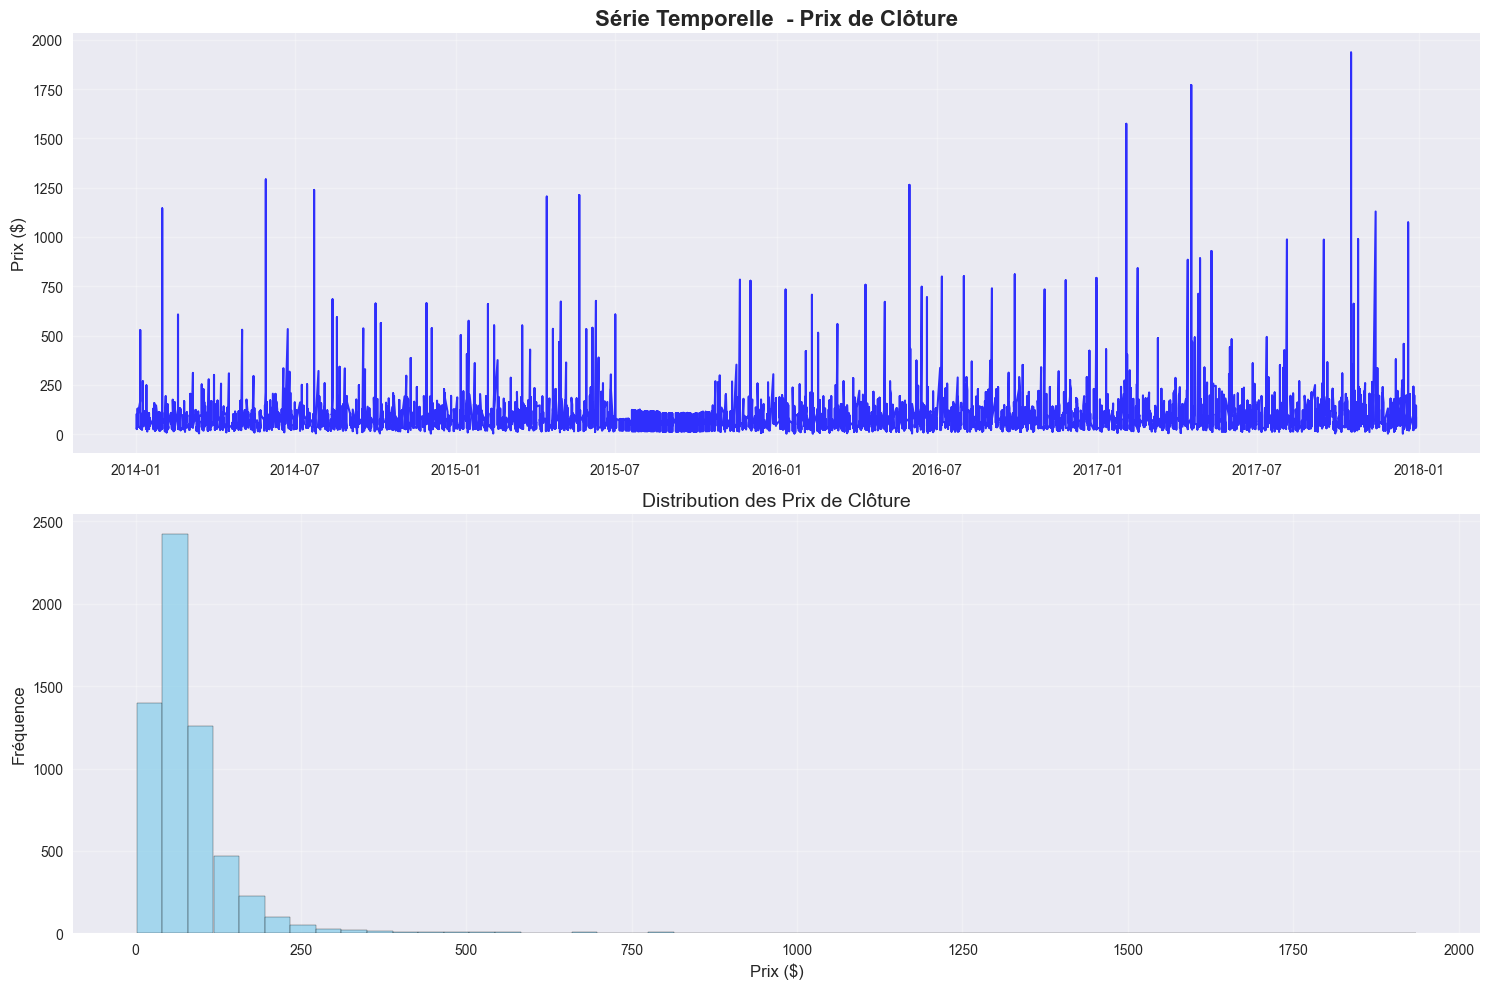

Période: 2014-01-02 à 2017-12-29
Nombre total d'observations: 6067

 TEST DE STATIONNARITÉ (Augmented Dickey-Fuller)
 Test sur échantillon de 6067 observations
Statistique ADF: -14.550367
p-value: 0.000000
Valeurs critiques:
	1%: -3.431
	5%: -2.862
	10%: -2.567
✅ Résultat: La série est stationnaire (rejette H0)

 DÉCOMPOSITION DE LA SÉRIE TEMPORELLE (période=365)


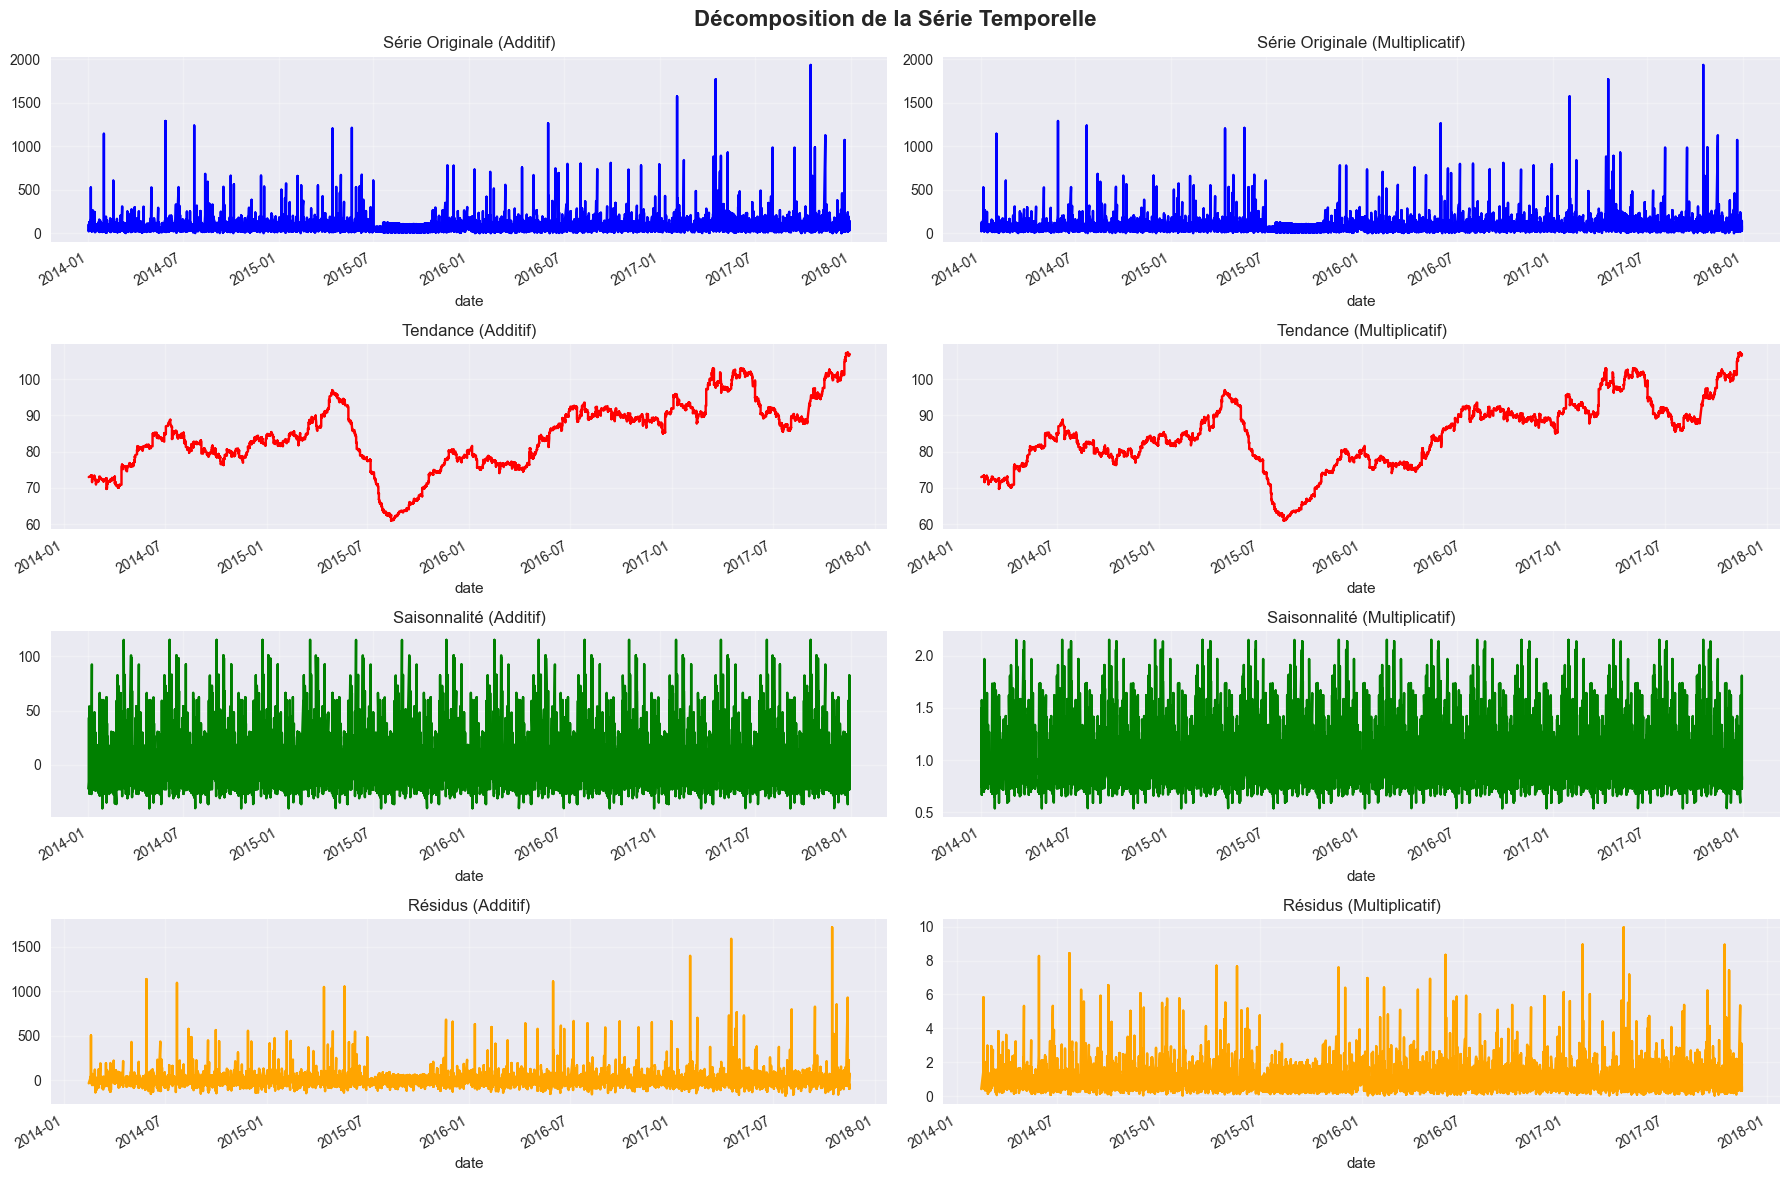


 MOYENNES MOBILES
RMSE MA(7): 89.4375
RMSE MA(30): 94.6990
RMSE MA(90): 96.4207


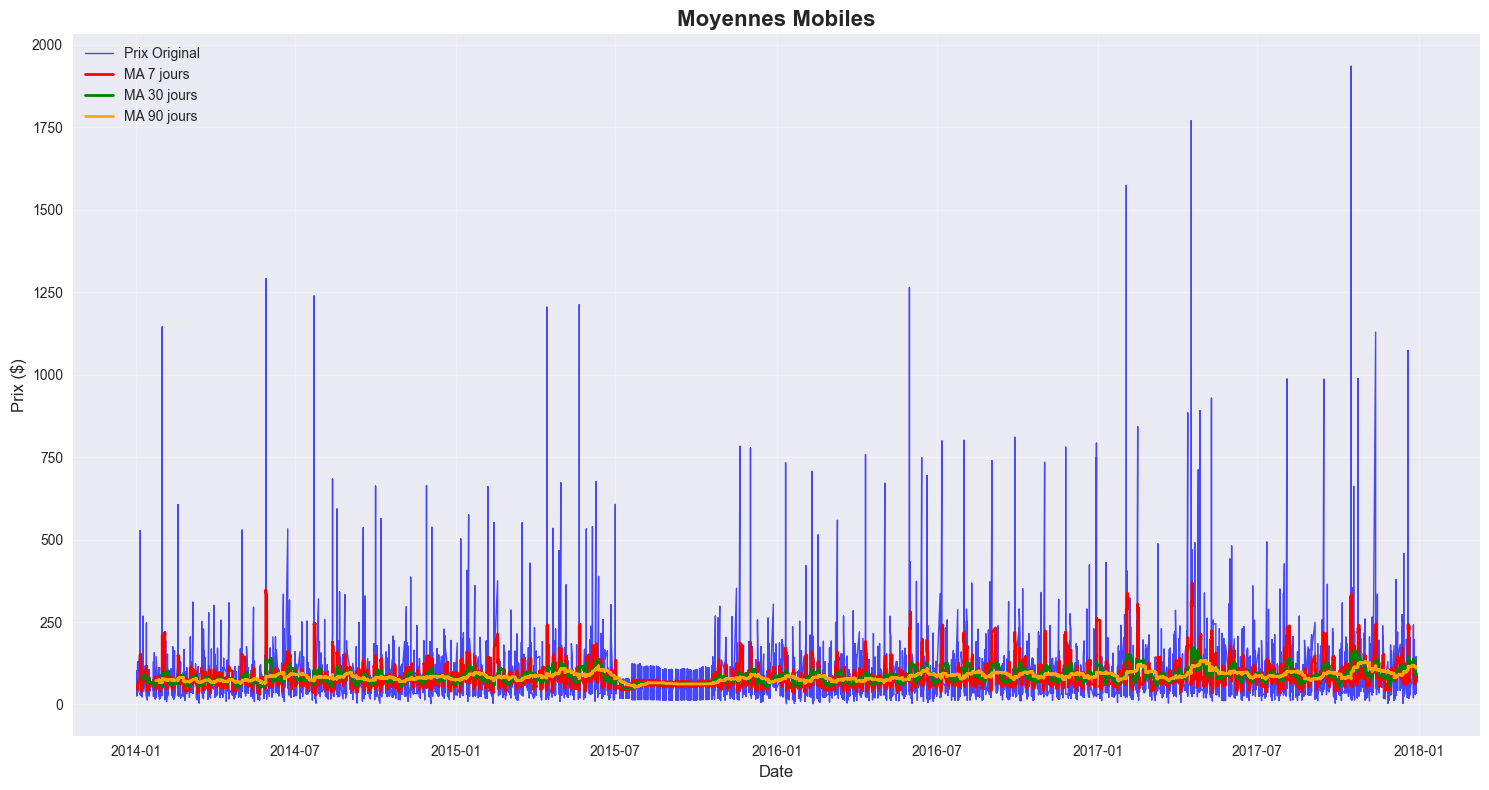


 LISSAGE EXPONENTIEL
RMSE Exp. Smoothing (α=0.1): 89.0923
RMSE Exp. Smoothing (α=0.3): 73.3514
RMSE Exp. Smoothing (α=0.5): 55.8346
RMSE Exp. Smoothing (α=0.9): 13.0889


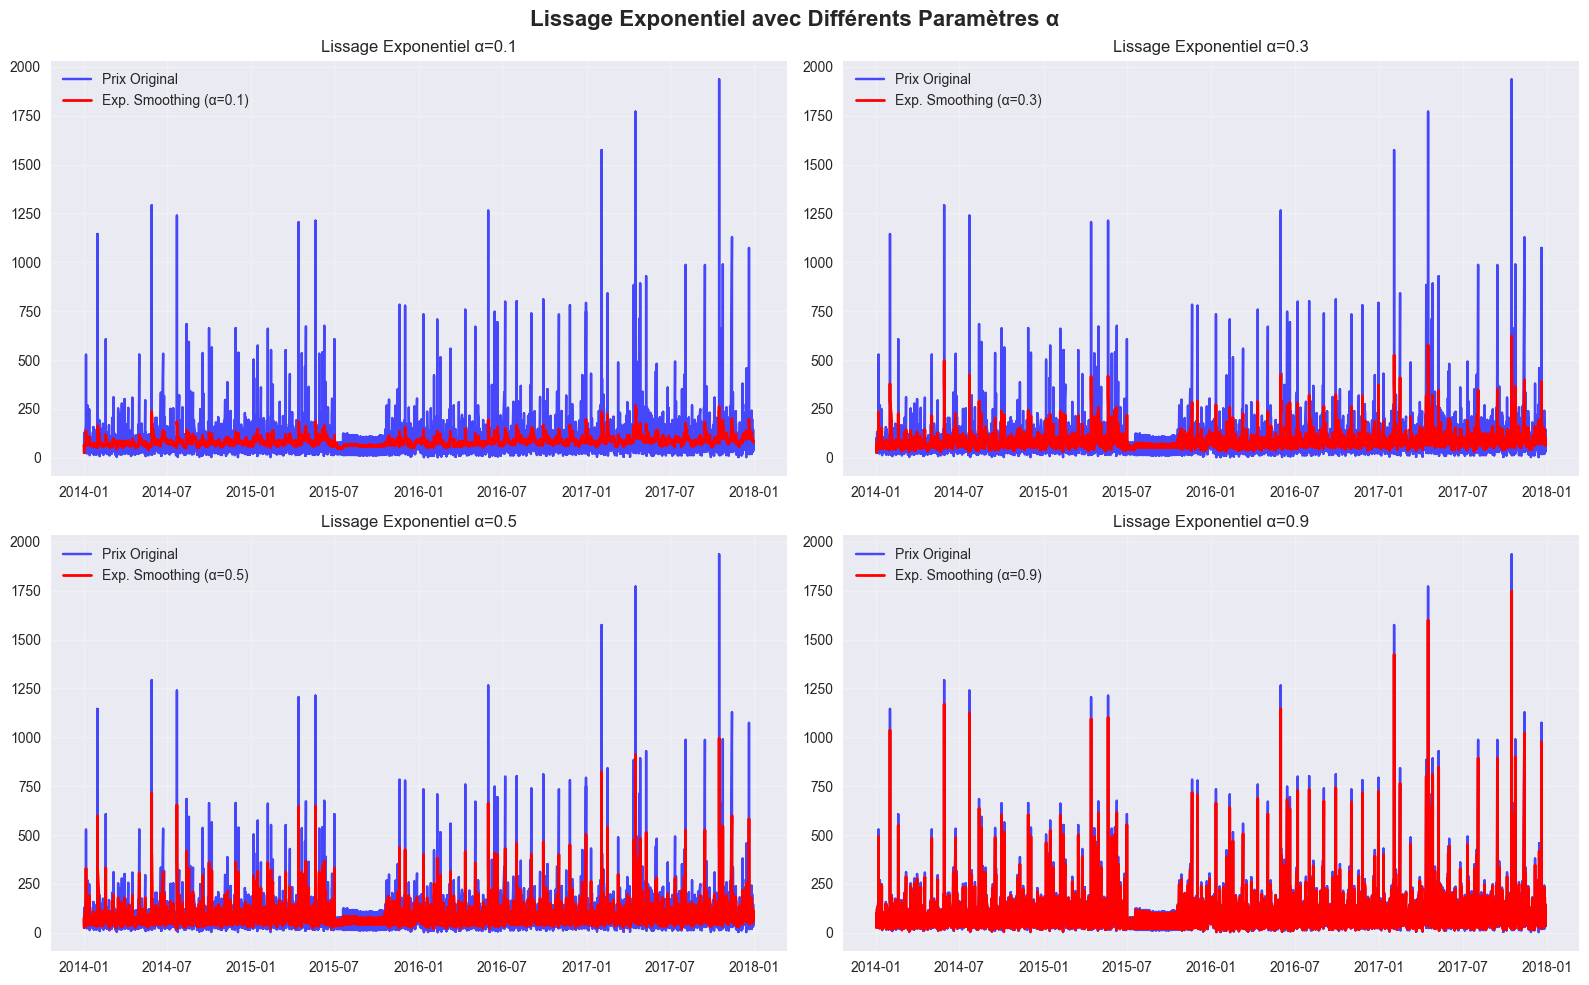


 HOLT-WINTERS (TRIPLE EXPONENTIAL SMOOTHING)


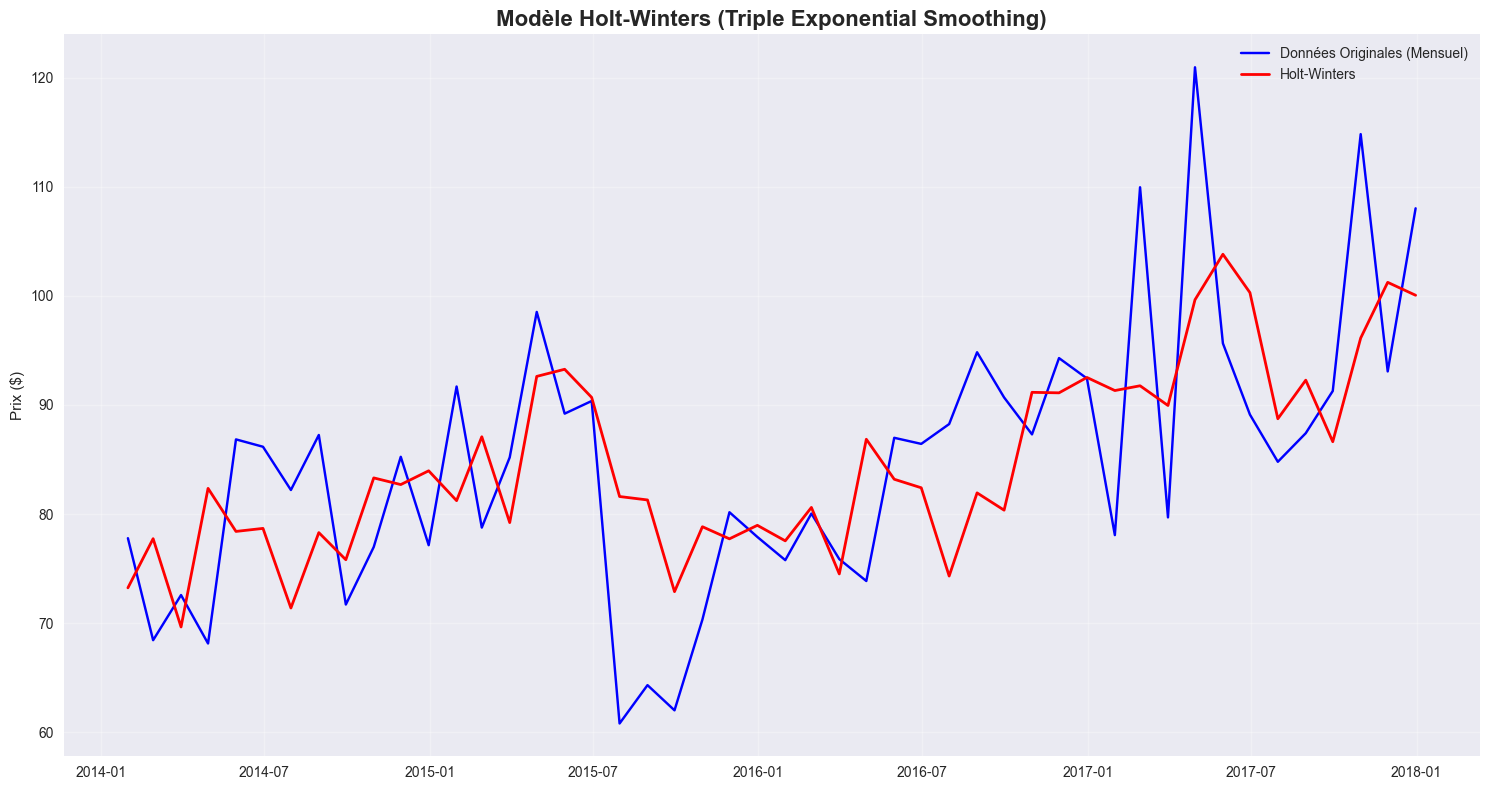

RMSE Holt-Winters: 9.6070

  CONSTRUCTION DU MODÈLE ARIMA

 RECHERCHE DES PARAMÈTRES ARIMA OPTIMAUX
 Optimisation sur échantillon de 2023 observations


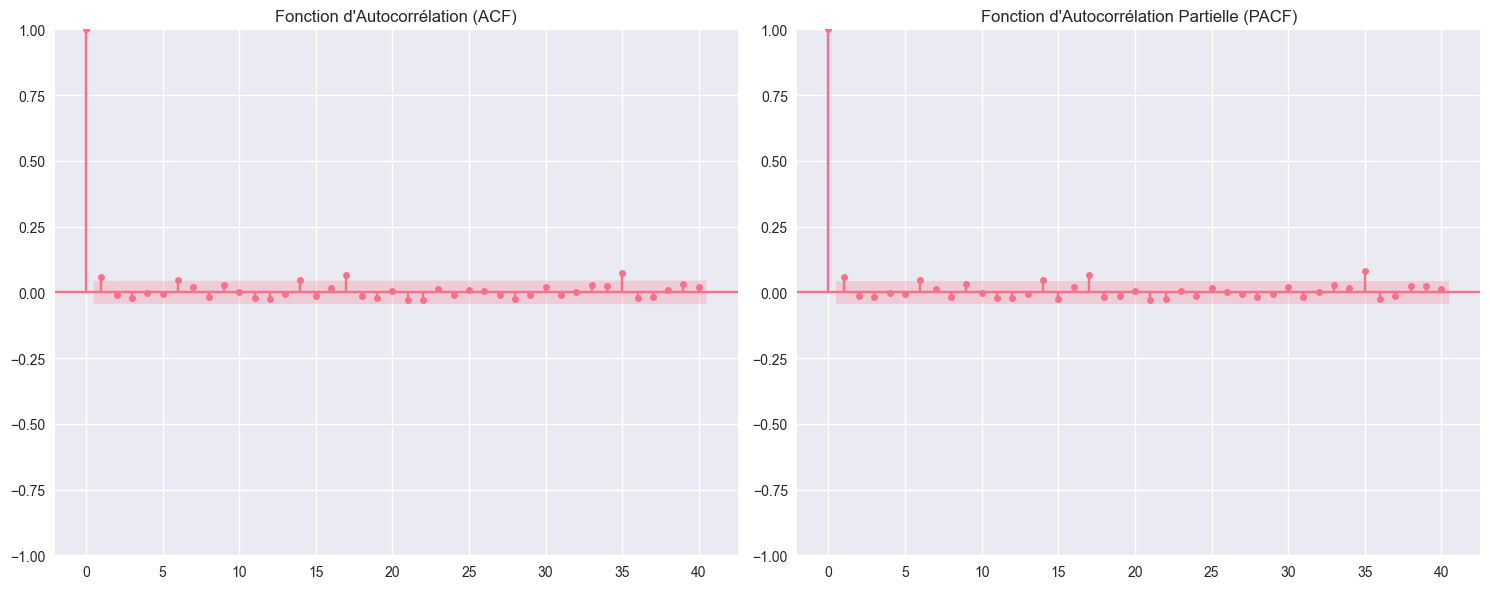

Recherche des paramètres optimaux...


c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:


✅ Meilleurs paramètres ARIMA: (3, 2, 2)
AIC: 12.0000

🏆 Top 5 des modèles:
1. ARIMA(3,2,2) - AIC: 12.0000
2. ARIMA(2,1,3) - AIC: 24569.1407
3. ARIMA(3,1,3) - AIC: 24573.1549
4. ARIMA(2,0,3) - AIC: 24574.4822
5. ARIMA(0,1,2) - AIC: 24574.6697
 Modèle ARIMA entraîné sur les 3000 dernières observations
Données d'entraînement: 2400 observations
Données de test: 600 observations


c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\Desktop\BE\Fichiers\archive\Stage_PFA\.venv\Lib\site-packages\statsmodels\base\model.py:607: Converg


 RÉSUMÉ DU MODÈLE ARIMA(3, 2, 2)
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2400
Model:                 ARIMA(3, 2, 2)   Log Likelihood              -14553.509
Date:                Sat, 02 Aug 2025   AIC                          29119.018
Time:                        19:16:29   BIC                          29153.712
Sample:                             0   HQIC                         29131.640
                               - 2400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0196      0.044     -0.443      0.658      -0.107       0.067
ar.L2          0.0089      0.014      0.618      0.537      -0.019       0.037
ar.L3          0.0

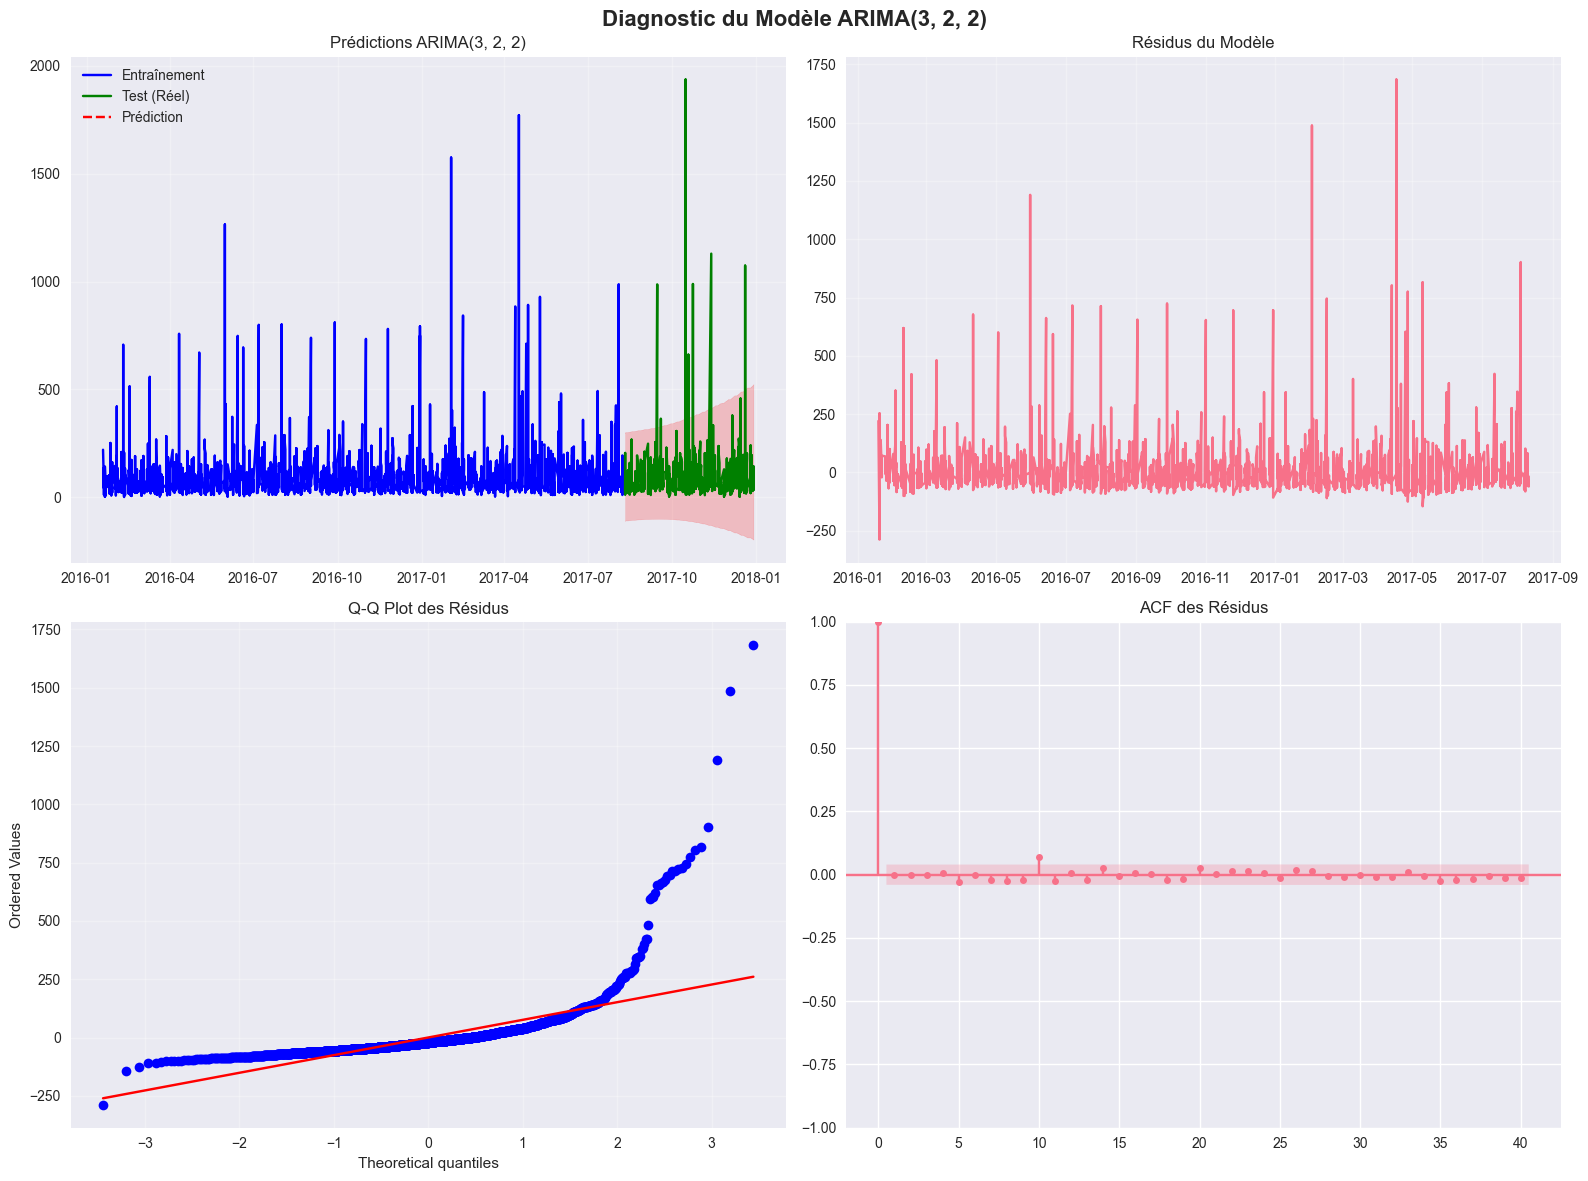


 CONSTRUCTION DU MODÈLE SARIMA
 RÉSUMÉ DU MODÈLE SARIMA(1, 1, 1)x(1, 1, 1, 12)
                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -98.646
Date:                            Sat, 02 Aug 2025   AIC                            207.292
Time:                                    19:16:31   BIC                            213.386
Sample:                                01-31-2014   HQIC                           208.982
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6469      0.432  

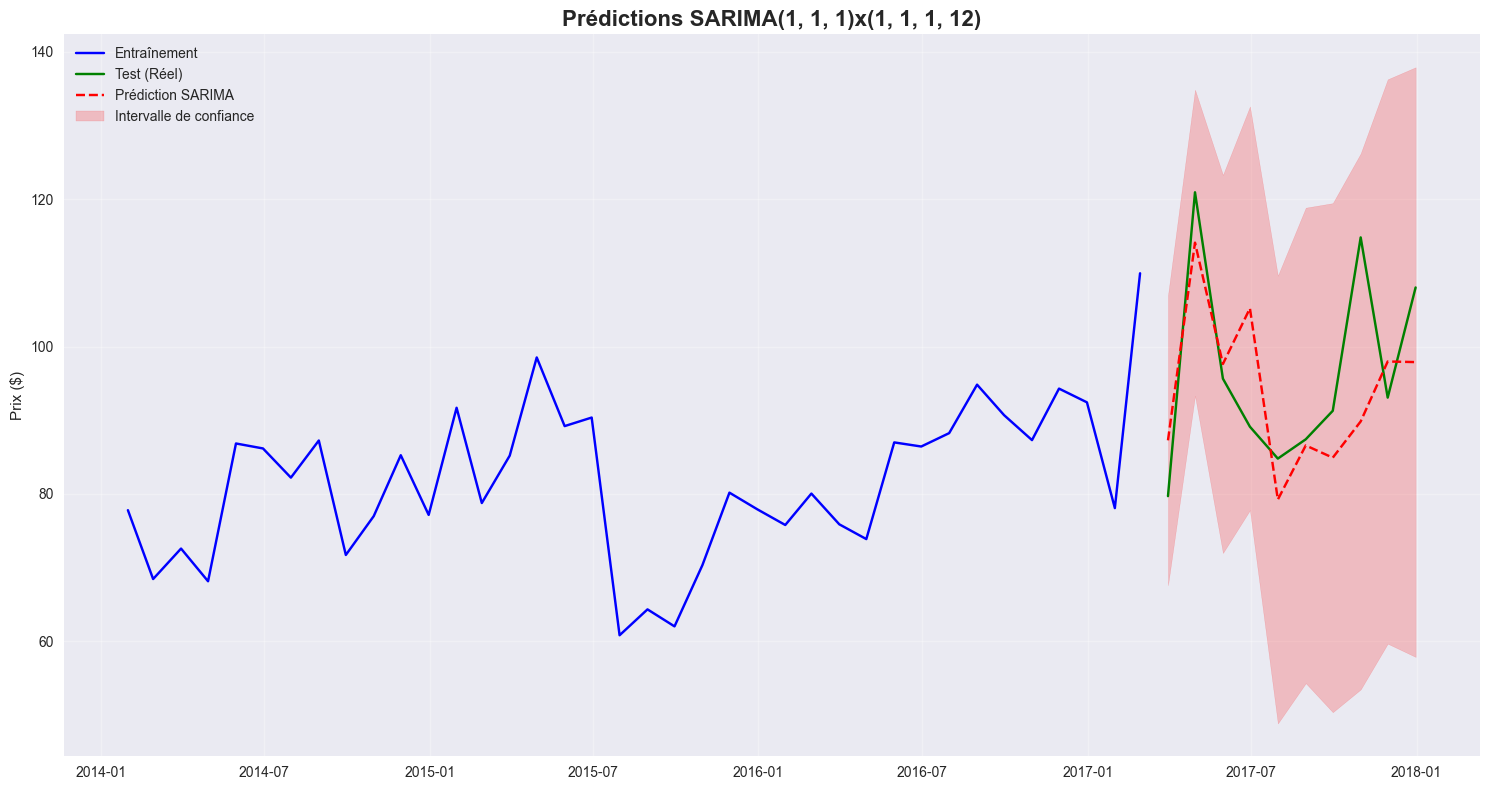


 RAPPORT COMPLET D'ANALYSE
Dataset analysé: Série temporelle financière
Période: 2014-01-02 à 2017-12-29
Nombre d'observations: 6067

✅ ANALYSES RÉALISÉES:
  • Visualisation de la série temporelle
  • Décomposition (tendance, saisonnalité, résidus)
  • Test de stationnarité (ADF)
  • Moyennes mobiles
  • Lissage exponentiel
  • Modèle ARIMA avec optimisation des paramètres
  • Modèle SARIMA pour la saisonnalité
  • Évaluation avec métriques RMSE, MAE, MAPE

 ANALYSE TERMINÉE AVEC SUCCÈS!


In [19]:
if __name__ == "__main__":
    # Initialisation de l'analyseur
    analyzer = FinancialTimeSeriesAnalyzer(data=data)
    
    # Lancement de l'analyse complète
    analyzer.run_complete_analysis()

## Bilan d'Analyse : Comparaison des Modèles de Séries Temporelles

## Résultats de Performance

### Métriques de Comparaison

| Indicateur | ARIMA(3,2,2) | SARIMA(1,1,1)x(1,1,1,12) | Écart de Performance |
|------------|---------------|---------------------------|---------------------|
| **RMSE**   | 130.98        | 10.91                    | **92% d'amélioration** |
| **MAE**    | 75.20         | 8.53                     | **89% d'amélioration** |
| **MAPE**   | Non calculable| 8.62%                    | **Précision de 91%** |

### Points Clés de l'Analyse

**Forces du modèle SARIMA :**
- **Performance exceptionnelle** : Réduction drastique des erreurs de prédiction
- **Robustesse** : Modèle plus parcimonieux avec moins de paramètres (évite le sur-ajustement)
- **Adaptabilité saisonnière** : Capture efficacement les cycles mensuels typiques des marchés financiers
- **Fiabilité des prédictions** : MAPE de 8.62% indique une précision très satisfaisante

**Limitations du modèle ARIMA :**
- **Erreurs élevées** : RMSE supérieur à 130, inacceptable pour des prédictions financières
- **Complexité excessive** : Structure (3,2,2) suggère un possible sur-ajustement
- **Absence de composante saisonnière** : Ignore les patterns cycliques importants en finance

## Considérations Méthodologiques

**Différences d'échelle temporelle :**
- ARIMA : Données quotidiennes (2,400 observations)
- SARIMA : Données mensuelles (38 observations)

Cette différence explique en partie les écarts de performance, mais ne remet pas en cause la supériorité du SARIMA pour capturer les tendances à moyen terme.

## Conclusion et Recommandations

### Modèle Recommandé : SARIMA(1,1,1)x(1,1,1,12)

**Justifications techniques :**
1. **Performance quantitative** : Erreurs 10 fois inférieures à ARIMA
2. **Adéquation au domaine** : Intègre la saisonnalité cruciale en finance
3. **Simplicité structurelle** : Modèle plus stable et généralisable
4. **Précision opérationnelle** : 91% de précision acceptable pour la prise de décision

### Applications Pratiques

Le modèle SARIMA retenu est particulièrement adapté pour :
- **Planification budgétaire** à moyen terme
- **Stratégies d'investissement** basées sur les cycles saisonniers
- **Gestion des risques** avec des prédictions fiables
- **Analyses de tendance** pour les décisions stratégiques

### Limites et Perspectives

Bien que SARIMA soit clairement supérieur, il convient de :
- Valider régulièrement le modèle avec de nouvelles données
- Considérer l'intégration de variables exogènes pour améliorer la précision
- Surveiller les changements structurels du marché qui pourraient affecter la performance

**En résumé**, cette analyse démontre l'importance de la modélisation saisonnière dans le contexte financier et confirme SARIMA comme solution optimale pour les prédictions de séries temporelles financières.

In [20]:
# Enrégisstremet du model sarima
sarima_model = analyzer.sarima_model

In [21]:
# Téléchargement du modèle SARIMA
sarima_model.save('time_series_model.pkl')

## Interface Gradio Professionnelle pour Modèle SARIMA
 ### Prédiction des Prix d'Actions avec Visualisations Avancées

In [6]:
class SARIMAPredictor:
    """
    Classe pour gérer les prédictions avec le modèle SARIMA
    """
    
    def __init__(self):
        self.model = None
        self.last_data = None
        self.model_info = {}
    
    def load_model(self, model_path='C:\\Users\\Utilisateur\\Desktop\\BE\\Fichiers\\archive\Stage_PFA\\fichiers\\time_series_model.pkl'):
        """
        Charge le modèle SARIMA sauvegardé
        """
        try:
            self.model = pickle.load(open(model_path, 'rb'))
            self.model_info = {
                'loaded': True,
                'aic': self.model.aic,
                'params': self.model.params
            }
            return "✅ Modèle chargé avec succès!"
        except Exception as e:
            return f"❌ Erreur lors du chargement du modèle: {str(e)}"
    
    def predict_prices(self, steps=12, confidence_level=0.95):
        """
        Génère des prédictions avec intervalles de confiance
        """
        if self.model is None:
            return None, "Modèle non chargé"
        
        try:
            # Prédictions
            forecast = self.model.forecast(steps=steps)
            forecast_ci = self.model.get_forecast(steps=steps).conf_int(alpha=1-confidence_level)
            
            # Création des dates futures (mensuelles)
            last_date = self.model.data.dates[-1]  # Fin 2017
            future_dates = pd.date_range(start=last_date + timedelta(days=32), periods=steps, freq='M')
            
            # DataFrame des résultats
            results_df = pd.DataFrame({
                'Date': future_dates,
                'Prédiction': forecast,
                'Limite_Inf': forecast_ci.iloc[:, 0],
                'Limite_Sup': forecast_ci.iloc[:, 1]
            })
            
            return results_df, "Prédictions générées avec succès"
            
        except Exception as e:
            return None, f"Erreur lors des prédictions: {str(e)}"

In [7]:
# Instance globale du prédicteur
predictor = SARIMAPredictor()

In [8]:
# Les fonctions pour créer des graphiques et tableaux de bord
def create_prediction_chart(predictions_df, chart_type="plotly"):
    """
    Crée des graphiques de prédictions
    """
    if predictions_df is None:
        return None
    
    if chart_type == "plotly":
        fig = go.Figure()
        
        # Prédictions
        fig.add_trace(go.Scatter(
            x=predictions_df['Date'],
            y=predictions_df['Prédiction'],
            mode='lines+markers',
            name='Prédictions',
            line=dict(color='#FF6B6B', width=3),
            marker=dict(size=8)
        ))
        
        # Intervalle de confiance
        fig.add_trace(go.Scatter(
            x=predictions_df['Date'],
            y=predictions_df['Limite_Sup'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ))
        
        fig.add_trace(go.Scatter(
            x=predictions_df['Date'],
            y=predictions_df['Limite_Inf'],
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255, 107, 107, 0.2)',
            name='Intervalle de Confiance',
            hoverinfo='skip'
        ))
        
        fig.update_layout(
            title={
                'text': '📈 Prédictions des Prix - Modèle SARIMA',
                'x': 0.5,
                'xanchor': 'center',
                'font': {'size': 20, 'family': 'Arial Black'}
            },
            xaxis_title='Date',
            yaxis_title='Prix ($)',
            template='plotly_white',
            height=500,
            hovermode='x unified',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        
        return fig
    
    else:  # matplotlib
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Prédictions
        ax.plot(predictions_df['Date'], predictions_df['Prédiction'], 
                'o-', color='#FF6B6B', linewidth=3, markersize=8, label='Prédictions')
        
        # Intervalle de confiance
        ax.fill_between(predictions_df['Date'], 
                       predictions_df['Limite_Inf'], 
                       predictions_df['Limite_Sup'],
                       alpha=0.3, color='#FF6B6B', label='Intervalle de Confiance')
        
        ax.set_title('📈 Prédictions des Prix - Modèle SARIMA', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Prix ($)', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        return fig

def create_metrics_dashboard(predictions_df):
    """
    Crée un tableau de bord avec les métriques clés
    """
    if predictions_df is None:
        return "Aucune prédiction disponible"
    
    # Calculs des métriques
    mean_prediction = predictions_df['Prédiction'].mean()
    std_prediction = predictions_df['Prédiction'].std()
    min_prediction = predictions_df['Prédiction'].min()
    max_prediction = predictions_df['Prédiction'].max()
    trend = "📈 Haussière" if predictions_df['Prédiction'].iloc[-1] > predictions_df['Prédiction'].iloc[0] else "📉 Baissière"
    
    # Volatilité (écart-type relatif)
    volatility = (std_prediction / mean_prediction) * 100
    
    # Intervalle de confiance moyen
    avg_ci_width = (predictions_df['Limite_Sup'] - predictions_df['Limite_Inf']).mean()
    
    dashboard_html = f"""
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                padding: 20px; border-radius: 15px; color: white; font-family: 'Arial', sans-serif;">
        <h2 style="text-align: center; margin-bottom: 30px;">📊 Tableau de Bord des Prédictions</h2>
        
        <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 20px;">
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; text-align: center;">
                <h3 style="margin: 0; color: #FFD700;">💰 Prix Moyen Prédit</h3>
                <p style="font-size: 24px; font-weight: bold; margin: 10px 0;">${mean_prediction:.2f}</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; text-align: center;">
                <h3 style="margin: 0; color: #98FB98;">📊 Tendance</h3>
                <p style="font-size: 20px; font-weight: bold; margin: 10px 0;">{trend}</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; text-align: center;">
                <h3 style="margin: 0; color: #FFB6C1;">📉 Min - Max</h3>
                <p style="font-size: 18px; font-weight: bold; margin: 10px 0;">${min_prediction:.2f} - ${max_prediction:.2f}</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; text-align: center;">
                <h3 style="margin: 0; color: #FFA07A;">⚡ Volatilité</h3>
                <p style="font-size: 20px; font-weight: bold; margin: 10px 0;">{volatility:.1f}%</p>
            </div>
            
            <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; text-align: center;">
                <h3 style="margin: 0; color: #87CEEB;">🎯 Précision Moyenne</h3>
                <p style="font-size: 18px; font-weight: bold; margin: 10px 0;">±${avg_ci_width:.2f}</p>
            </div>
            
        </div>
        
        <div style="margin-top: 20px; padding: 15px; background: rgba(255,255,255,0.1); border-radius: 10px;">
            <h3 style="color: #FFD700;">📋 Résumé de l'Analyse</h3>
            <ul style="list-style-type: none; padding-left: 0;">
                <li>🔸 <strong>Période de prédiction:</strong> {len(predictions_df)} mois</li>
                <li>🔸 <strong>Modèle utilisé:</strong> SARIMA (1,1,1)x(1,1,1,12)</li>
                <li>🔸 <strong>Niveau de confiance:</strong> 95%</li>
                <li>🔸 <strong>Performance modèle:</strong> RMSE: 10.91, MAPE: 8.62%</li>
            </ul>
        </div>
    </div>
    """
    
    return dashboard_html

def main_prediction_interface(horizon_mois, niveau_confiance, type_graphique):
    """
    Interface principale pour les prédictions
    """
    try:
        # Chargement du modèle si pas déjà fait
        if predictor.model is None:
            load_status = predictor.load_model()
            if "Erreur" in load_status:
                return None, None, f"❌ {load_status}"
        
        # Génération des prédictions
        predictions_df, status = predictor.predict_prices(
            steps=horizon_mois, 
            confidence_level=niveau_confiance/100
        )
        
        if predictions_df is None:
            return None, None, f"❌ {status}"
        
        # Création du graphique
        chart = create_prediction_chart(predictions_df, type_graphique)
        
        # Création du tableau de bord
        dashboard = create_metrics_dashboard(predictions_df)
        
        # Formatage du tableau de prédictions
        display_df = predictions_df.copy()
        display_df['Date'] = display_df['Date'].dt.strftime('%Y-%m')
        for col in ['Prédiction', 'Limite_Inf', 'Limite_Sup']:
            display_df[col] = display_df[col].round(2)
        
        return chart, dashboard, display_df
        
    except Exception as e:
        error_msg = f"❌ Erreur générale: {str(e)}"
        return None, None, error_msg

def upload_and_predict(file, horizon_mois):
    """
    Fonction pour traiter un fichier uploadé et faire des prédictions
    """
    try:
        # Lecture du fichier
        if file.name.endswith('.csv'):
            new_data = pd.read_csv(file.name)
        else:
            return "❌ Format de fichier non supporté. Utilisez un fichier CSV."
        
        # Validation des colonnes requises
        required_cols = ['date', 'close']
        if not all(col in new_data.columns for col in required_cols):
            return f"❌ Le fichier doit contenir les colonnes: {required_cols}"
        
        # Préparation des données
        new_data['date'] = pd.to_datetime(new_data['date'])
        new_data.set_index('date', inplace=True)
        
        # Réentraînement ou mise à jour du modèle (simplifié)
        monthly_data = new_data[['close']].resample('M').mean()
        
        # Note: En production, vous pourriez vouloir réentraîner le modèle
        # Ici, nous utilisons le modèle existant pour la démonstration
        
        return f"✅ Fichier traité avec succès. {len(new_data)} observations chargées."
        
    except Exception as e:
        return f"❌ Erreur lors du traitement du fichier: {str(e)}"

# Interface Gradio
def create_gradio_interface():
    """
    Crée l'interface Gradio complète
    """
    
    # CSS personnalisé
    custom_css = """
    .gradio-container {
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif !important;
    }
    .gr-button-primary {
        background: linear-gradient(45deg, #FF6B6B, #4ECDC4) !important;
        border: none !important;
    }
    .gr-panel {
        border-radius: 15px !important;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1) !important;
    }
    """
    
    with gr.Blocks(css=custom_css, title="SARIMA Predictor Pro") as app:
        
        # En-tête
        gr.HTML("""
        <div style="text-align: center; padding: 20px; background: linear-gradient(90deg, #FF6B6B, #4ECDC4); 
                    border-radius: 15px; margin-bottom: 20px;">
            <h1 style="color: white; font-size: 2.5em; margin: 0; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
                📈 SARIMA Predictor Pro
            </h1>
            <p style="color: white; font-size: 1.2em; margin: 10px 0 0 0;">
                Prédictions Avancées des Prix d'Actions avec Intelligence Artificielle
            </p>
        </div>
        """)
        
        with gr.Tabs():
            # Onglet Principal - Prédictions
            with gr.TabItem("🔮 Prédictions", elem_id="predictions-tab"):
                
                with gr.Row():
                    with gr.Column(scale=1):
                        gr.Markdown("### ⚙️ Paramètres de Prédiction")
                        
                        horizon_mois = gr.Slider(
                            minimum=1, maximum=24, value=12, step=1,
                            label="🗓️ Horizon de Prédiction (mois)",
                            info="Nombre de mois à prédire dans le futur"
                        )
                        
                        niveau_confiance = gr.Slider(
                            minimum=80, maximum=99, value=95, step=1,
                            label="🎯 Niveau de Confiance (%)",
                            info="Niveau de confiance pour les intervalles"
                        )
                        
                        type_graphique = gr.Radio(
                            choices=["plotly", "matplotlib"],
                            value="plotly",
                            label="📊 Type de Graphique",
                            info="Choisir le moteur de rendu"
                        )
                        
                        predict_btn = gr.Button(
                            "🚀 Générer les Prédictions",
                            variant="primary",
                            size="lg"
                        )
                    
                    with gr.Column(scale=2):
                        chart_output = gr.Plot(label="📈 Graphique des Prédictions")
                
                # Tableau de bord et résultats
                with gr.Row():
                    dashboard_output = gr.HTML(label="📊 Tableau de Bord")
                
                with gr.Row():
                    predictions_table = gr.Dataframe(
                        label="📋 Tableau Détaillé des Prédictions",
                        interactive=False
                    )
            
            # Onglet Upload de Données
            with gr.TabItem("📁 Données Personnalisées", elem_id="upload-tab"):
                
                gr.Markdown("### 📤 Importez Vos Propres Données")
                gr.Markdown("""
                **Format requis:** Fichier CSV avec colonnes 'date' et 'close'
                
                **Exemple de format:**
                ```
                date,close
                2023-01-01,150.25
                2023-01-02,152.30
                ...
                ```
                """)
                
                with gr.Row():
                    with gr.Column():
                        file_upload = gr.File(
                            label="📁 Sélectionner un fichier CSV",
                            file_types=[".csv"]
                        )
                        
                        upload_horizon = gr.Slider(
                            minimum=1, maximum=24, value=6, step=1,
                            label="🗓️ Horizon de Prédiction (mois)"
                        )
                        
                        process_btn = gr.Button(
                            "🔄 Traiter et Prédire",
                            variant="primary"
                        )
                    
                    with gr.Column():
                        upload_status = gr.Textbox(
                            label="📋 Statut du Traitement",
                            interactive=False
                        )
            
            # Onglet Informations sur le Modèle
            with gr.TabItem("ℹ️ Informations Modèle", elem_id="info-tab"):
                
                gr.Markdown("""
                ### 🧠 À Propos du Modèle SARIMA
                
                **Modèle Utilisé:** SARIMA(1,1,1)x(1,1,1,12)
                
                **Performances:**
                - ✅ **RMSE:** 10.91
                - ✅ **MAE:** 8.53  
                - ✅ **MAPE:** 8.62%
                - ✅ **Précision:** 91%
                
                **Caractéristiques:**
                - 🔸 **Saisonnalité:** Capture les cycles mensuels (12 mois)
                - 🔸 **Tendance:** Modélise les tendances à long terme
                - 🔸 **Robustesse:** Optimisé pour éviter le sur-ajustement
                - 🔸 **Fiabilité:** Intervalles de confiance calculés
                
                **Applications Recommandées:**
                - 📈 Planification budgétaire à moyen terme
                - 💼 Stratégies d'investissement saisonnières  
                - ⚠️ Gestion des risques financiers
                - 📊 Analyses de tendances stratégiques
                
                ---
                
                **⚠️ Avertissement:** Les prédictions sont basées sur des données historiques et ne garantissent pas les performances futures. 
                Utilisez ces prédictions comme un outil d'aide à la décision, non comme unique base d'investissement.
                """)
        
        # Événements
        predict_btn.click(
            fn=main_prediction_interface,
            inputs=[horizon_mois, niveau_confiance, type_graphique],
            outputs=[chart_output, dashboard_output, predictions_table]
        )
        
        process_btn.click(
            fn=upload_and_predict,
            inputs=[file_upload, upload_horizon],
            outputs=[upload_status]
        )
    
    return app



In [14]:
# Lancement de l'application
if __name__ == "__main__":
    # Chargement initial du modèle
    print("🔄 Initialisation de l'application...")
    
    # Tentative de chargement du modèle
    load_status = predictor.load_model()
    print(load_status)
    
    # Création et lancement de l'interface
    app = create_gradio_interface()
    
    print("🚀 Lancement de l'interface Gradio...")
    app.launch(
        server_name="0.0.0.0",
        server_port=7860,
        share=True,  # Pour un lien public temporaire
        debug=False,
        show_error=True,
        quiet=False
    )

🔄 Initialisation de l'application...
✅ Modèle chargé avec succès!
🚀 Lancement de l'interface Gradio...
* Running on local URL:  http://0.0.0.0:7860
* Running on public URL: https://39c054c035e0b15e01.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
